<u>Downloading `cv2` module:</u>

In [ ]:
! pip install opencv-python

> <a href="https://docs.opencv.org/4.x/d5/de5/tutorial_py_setup_in_windows.html">Documentation</a> <br>
<a href="https://stackoverflow.com/questions/51853018/how-do-i-install-opencv-using-pip">`cv2` installation troublshoot</a>
>

# <u>"<a href="https://www.youtube.com/watch?v=ADV-AjAXHdc">How to Preprocess Images for Text OCR in Python (OCR in Python Tutorials 02.02)</a>":</u>

<a href="https://github.com/wjbmattingly/ocr_python_textbook/tree/main">wjbmattingly's GitHub for "ocr-python-textbook"</a>

# 00: Opening an Image

In [ ]:
import cv2
img_file = "page_01.jpg"
img = cv2.imread(img_file)

cv2.imshow("original image", img)
cv2.waitKey(0) # python might crash if this display method is ran a couple of times

In [ ]:
import matplotlib.pyplot as plt

"""https://stackoverflow.com/questions/28816046/displaying-different-images-with-actual-size-in-matplotlib-subplot"""
def matplotlib_display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()
    
matplotlib_display(img_file) # can also use IPython.display ...

# 01: Inverted Images

In [ ]:
import cv2
from IPython.display import display, Image

inv_img = cv2.bitwise_not(img) # inverted image data
cv2.imwrite("cv2_results/inverted.jpg", inv_img)

display(Image("cv2_results/inverted.jpg"))

# 02: Rescaling

In [ ]:
# skipped for another video...

# 03: Binarization

In [ ]:
import cv2 

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

img_gray = grayscale(img)
cv2.imwrite("cv2_results/gray.jpg", img_gray)

cv2.imshow("gray.jpg", img_gray)
cv2.waitKey(0) # the matplotlib_display() function ended up not working on 'gray.jpg' for some reason

In [ ]:
import cv2
from IPython.display import display, Image

thresh1, img_bw1 = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY) # just a demonstration
cv2.imwrite("cv2_results/bw_image1.jpg", img_bw1)

display(Image("cv2_results/bw_image1.jpg"))

In [ ]:
import cv2
from IPython.display import display, Image

thresh2, img_bw2 = cv2.threshold(img_gray, 210, 230, cv2.THRESH_BINARY) # funny enough 200,230 fixed all the noise...
cv2.imwrite("cv2_results/bw_image2.jpg", img_bw2)

display(Image("cv2_results/bw_image2.jpg"))

# 04: Noise Removal

In [ ]:
from IPython.display import display, Image
import numpy as np

def noise_removal(image):
    ker = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, ker, iterations=1)
    image = cv2.erode(image, ker, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, ker)
    image = cv2.medianBlur(image, 3)
    return image

no_noise = noise_removal(img_bw2)
cv2.imwrite("cv2_results/no_noise.jpg", no_noise)

display(Image("cv2_results/no_noise.jpg"))

# 05: Dilation and Erosion

In [ ]:
import cv2
import numpy as np

def thin_font(image):
    image = cv2.bitwise_not(image)
    ker = np.ones((2,2), np.uint8)
    image = cv2.erode(image, ker, iterations=1)
    image = cv2.bitwise_not(image)
    return image

eroded_image = thin_font(no_noise)
cv2.imwrite("cv2_results/eroded_image.jpg", eroded_image)

display(Image("cv2_results/eroded_image.jpg"))

In [ ]:
import cv2
import numpy as np

def thick_font(image):
    image = cv2.bitwise_not(image)
    ker = np.ones((2,2), np.uint8)
    image = cv2.dilate(image, ker, iterations=1) # dilate will expand the pixel
    image = cv2.bitwise_not(image)
    return image

dilated_image = thick_font(no_noise)
cv2.imwrite("cv2_results/dilated_image.jpg", dilated_image)

display(Image("cv2_results/dilated_image.jpg"))

# 06: Rotation / Deskewing

In [ ]:
import cv2
from IPython.display import display, Image

new = cv2.imread("page_01_rotated.jpg")
display(Image("page_01_rotated.jpg"))

In [ ]:
# https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import cv2
from IPython.display import display, Image

# Calculate skew angle of an image
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

"""removing borders before this preprocessing image should be done first""";

fixed = deskew(new)
cv2.imwrite("cv2_results/rotated_fixed.jpg", fixed)
display(Image("cv2_results/rotated_fixed.jpg")) # doesn't work...

# 07: Removing Borders

In [ ]:
import cv2
from IPython.display import display, Image

def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

no_borders = remove_borders(no_noise)
cv2.imwrite("cv2_results/no_border.jpg", no_borders)
display(Image("cv2_results/no_border.jpg")) # the professor tells us many caveats for this function...

# 08: Missing Borders

In [ ]:
import cv2
from IPython.display import display, Image

color = [255, 255, 255]
top, bottom, left, right = [150]*4

image_with_border = cv2.copyMakeBorder(no_borders, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
cv2.imwrite("cv2_results/image_with_border.jpg", image_with_border)
display(Image("cv2_results/image_with_border.jpg"))

# <a href="https://www.youtube.com/watch?v=9FCw1xo_s0I">How to use Bounding Boxes with OpenCV (OCR in Python Tutorials 03.02)</a>

In [ ]:
import pytesseract
import cv2
from IPython.display import display, Image

image = cv2.imread("index_02.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite("cv2_results/index_gray.jpg", gray)

display(Image("cv2_results/index_gray.jpg"))

In [ ]:
blur = cv2.GaussianBlur(gray, (7,7), 0) # (7,7) is the size of the blurring
cv2.imwrite("cv2_results/index_blur.jpg", blur)

display(Image("cv2_results/index_blur.jpg"))

In [ ]:
thresh3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
cv2.imwrite("cv2_results/index_thresh.jpg", thresh3)

display(Image("cv2_results/index_thresh.jpg"))

In [ ]:
ker = cv2.getStructuringElement(cv2.MORPH_RECT, (3,13))
dilate = cv2.dilate(thresh3, ker, iterations=1)

cv2.imwrite("cv2_results/index_dilate.jpg", dilate)
display(Image("cv2_results/index_dilate.jpg"))

In [ ]:
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])
green = (36, 255, 12) # industry standard for bounding box

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x+w, y+h), green, 2)
    
cv2.imwrite("cv2_results/index_bbox1.jpg", image)
display(Image("cv2_results/index_bbox1.jpg"))

<i>So essentially...</i>

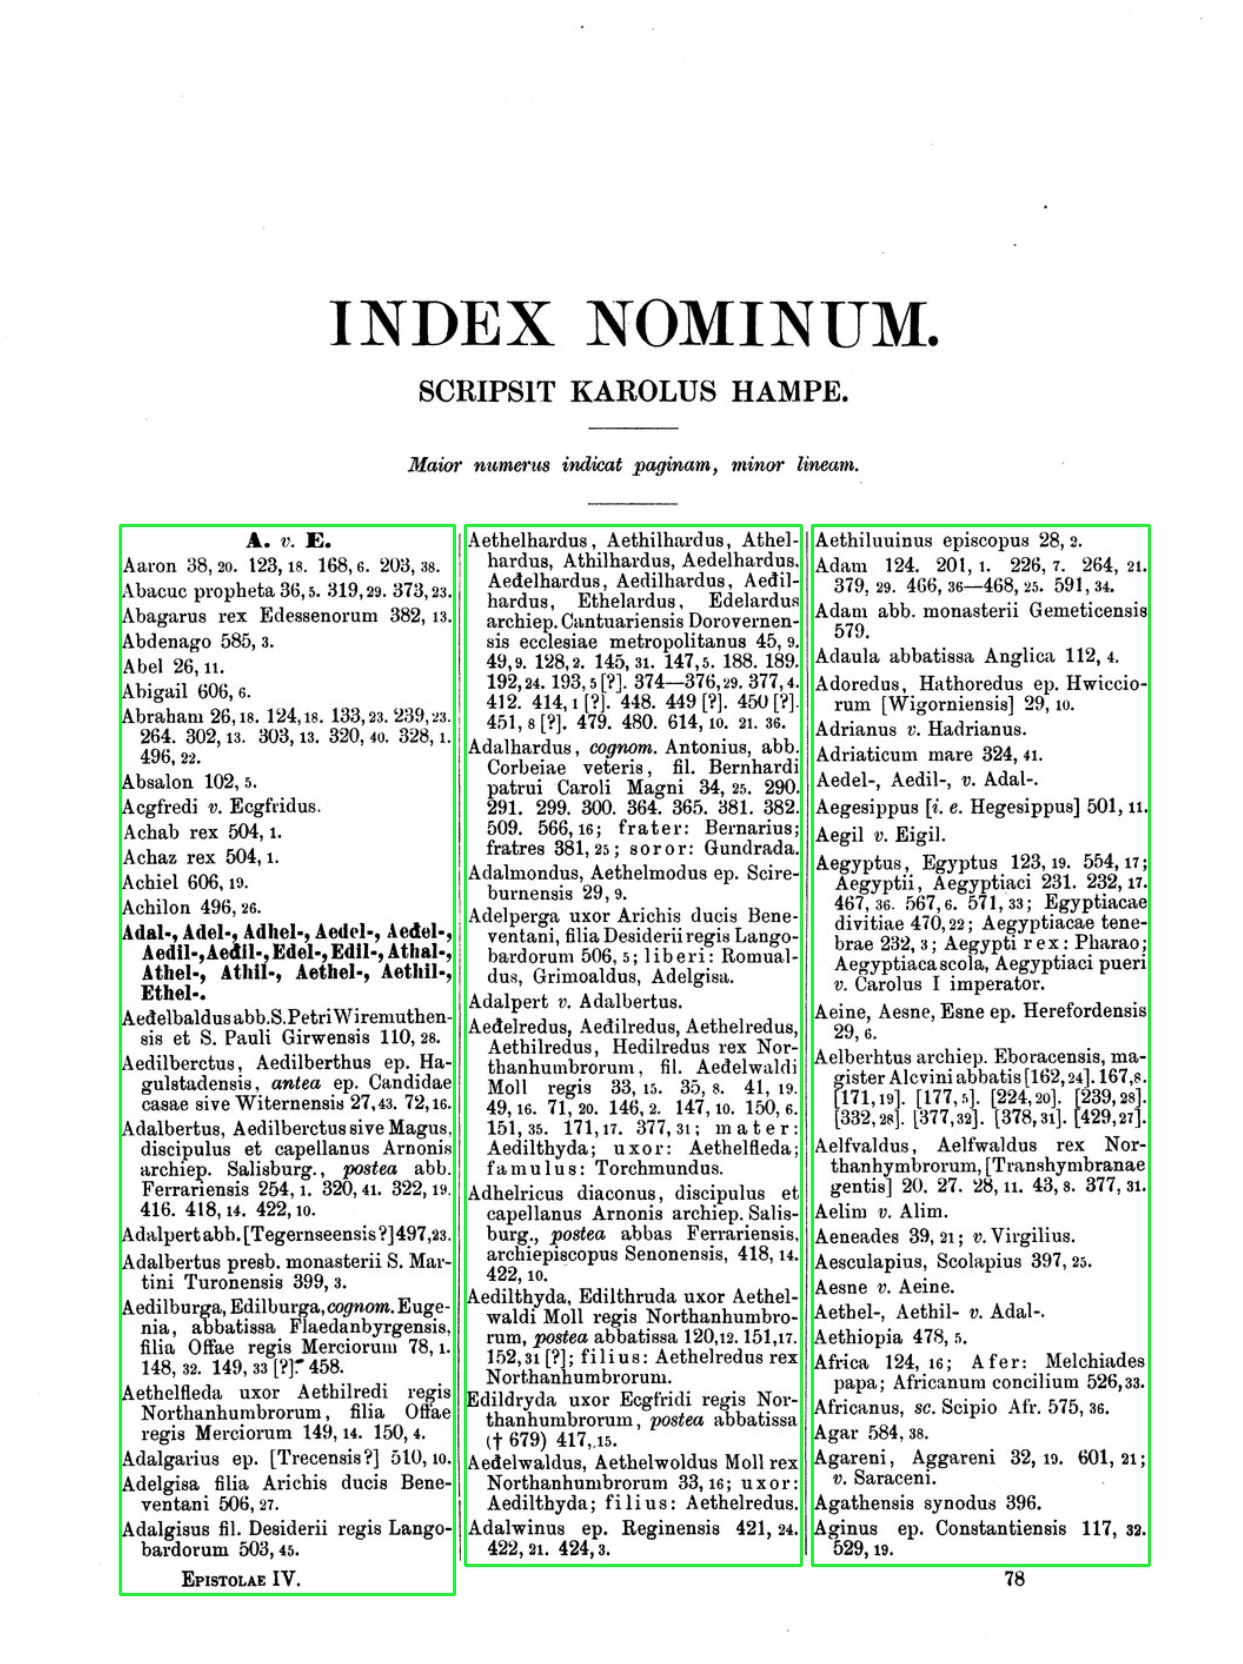

In [1]:
import cv2
from IPython.display import display, Image

image = cv2.imread("index_02.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0) # (7,7) is the size of the blurring
thresh3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
ker = cv2.getStructuringElement(cv2.MORPH_RECT, (3,13))
dilate = cv2.dilate(thresh3, ker, iterations=1)

cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])
green = (36, 255, 12) # industry standard for bounding box

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if h > 200 and w > 20: # filtering the bounding box
        roi = image[y:y+h, x:x+w]
        cv2.imwrite("cv2_results/index_roi.jpg", roi) # saves one of the column
        cv2.rectangle(image, (x, y), (x+w, y+h), green, 2)
    
cv2.imwrite("cv2_results/index_bbox2.jpg", image)
display(Image("cv2_results/index_bbox2.jpg"))

<i>Now to OCR our ROI...</i>

In [2]:
import pytesseract
import cv2
from IPython.display import display, Image
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\JetBl\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

image = cv2.imread("index_02.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0) # (7,7) is the size of the blurring
thresh3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
ker = cv2.getStructuringElement(cv2.MORPH_RECT, (3,13))
dilate = cv2.dilate(thresh3, ker, iterations=1)

cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])
green = (36, 255, 12) # industry standard for bounding box

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if h > 200 and w > 20: # filtering the bounding box
        roi = image[y:y+h, x:x+w]
        cv2.rectangle(image, (x, y), (x+w, y+h), green, 2)
        ocr_result = pytesseract.image_to_string(roi)
        ocr_result = ocr_result.split("\n")
        for i in ocr_result:
            print(i.strip())

A. v. E.

Aaron 38, 20. 123, 18. 168, 6. 203, 38.
Abacuc propheta 36,5. 319,29. 373, 23.
Abagarus rex Edessenorum 382, 13.
Abdenago 585, 3.
Abel 26, 11.
Abigail 606, 6.
Abraham 26,18, 124,18. 133, 23.
264. 302, 13. 303, 13. 320, 40.
496, 22.
Absalon 102, 5.
Acgfredi v. Ecgtridus.
Achab rex 504, 1.
Achaz rex 504, 1.
Achiel 606, 19.
Achilon 496, 26.
Adal-, Adel-, Adhel-, Aedel-, Aed

Aedil-, Aedil- Edel-, Edil-, Athal-,
Athel-, Athil-, Aethel-, Aethil-,
Ethel-.
Aedelbaldusabb.S. Petri Wiremuthen-
sis et S. Pauli Girwensis 110, 28.
Aedilberctus, Aedilberthus ep. Ha-
gulstadensis, antea ep. Candidae
casae sive Witernensis 27,43. 72,16.
Adalbertus, Aedilberctus sive Magus,
discipulus et capellanus Arnonis
archiep. Salisburg., postea_abb.
Ferrariensis 254, 1. 320, 41. 322, 19.
416. 418, 14. 422, 10.
Adalpertabb.[Tegernseensis ?]497,23.
Adalbertus presb. monasterii S. Mar-
tini Turonensis 399, 3.
Aedilburga, Edilburga, cognom. Euge-
nia, abbatissa Flaedanbyrgensis,
filia Offae regis Merciorum